My goal was to use fastai and to experiment with this Kaggle dataset of CT scans (https://www.kaggle.com/plameneduardo/a-covid-multiclass-dataset-of-ct-scans)  
I've chosen to work with the images from healthy patients and the ones diagnosed with Covid-19. I have taken a data-centric approach. My initial goal was to do well on the training set as a milestone of doing well on the test set. I have manually moved images around so they are stored in a structure suitable for model training, carefully avoiding data leakage, on a small training dataset, before scaling up the dataset.

1. CT scans in png format: 80 CT scans for healthy patients and 80 CT scans for patients infected by SARS-CoV-2 for training, 20 CT scans for healthy patients and 20 CT scans for patients infected by SARS-CoV-2 for validation, and 20 CT scans for healthy patients and 20 CT scans for patients infected by SARS-CoV-2 for testing.  

2. A pretrained model that has already been trained on 1.3
million images.  

3. The pretrained model will be fine-tuned using transfer learning to create a model that is
specially customized for recognizing covid-19 and healthy CT lung scans.

**Future work**:  
· Unfreeze the model and train all the layers by using different learning rates for different layers. For the early layers of the model using lower learning rate, because the things learned by those layers are common in computer vision tasks and I want to not change their weights very much. And a higher learning rate for the layers as we go deeper in the model to adapt them to the new task.  

· See how class imbalance negatively affects model evaluation. (There are several techniques to deal with class imbalance. A very popular one is SMOTE, which oversamples the minority classes by creating syntethic data.)   

· Do well on test set   

· Doing well on project metrics -> Hypothesis testing

In [2]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

# confusion matrix plotting
from sklearn.metrics import confusion_matrix, accuracy_score


if torch.cuda.is_available():     # Use GPU, if available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

ImageDataLoaders.from_folder(path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None, batch_tfms=None, bs=64, val_bs=None, shuffle=True, device=None)
Create from imagenet style dataset in path with train and valid subfolders (or provide valid_pct)

If valid_pct is provided, a random split is performed (with an optional seed) by setting aside that percentage of the data for the validation set (instead of looking at the grandparents folder).

In [20]:
from fastai.vision.all import *
path = "/Users/nadia/Documents/Tech projects/CTscansUBB/dataTrainVal/"

# is_healthy: this function returns the CT scans for healthy patients.
# The images for the training set are in the dataTrainVal folder, 
# mentioned in the path. There, the images with CT scans for healthy patients
# are named as 'Healthy_0x'. 
# I will resize the images to 64 and use resnet34 for transfer learning
def is_healthy(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
path, get_image_files(path), seed=42,
label_func=is_healthy, item_tfms=Resize(64))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(100)

epoch,train_loss,valid_loss,error_rate,time
0,1.137359,1.865458,0.435897,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.219605,1.430491,0.435897,00:06
1,0.995993,1.131304,0.384615,00:06
2,0.950041,0.928861,0.384615,00:06
3,0.905913,0.722194,0.282051,00:06
4,0.867081,0.547669,0.282051,00:06
5,0.819224,0.436846,0.205128,00:06
6,0.755632,0.406637,0.179487,00:06
7,0.726314,0.384562,0.179487,00:06
8,0.678656,0.403767,0.256410,00:06
9,0.637742,0.405372,0.205128,00:06


How good is the model? In the last column of
the table, you can see the error rate, which is the proportion of
images that were incorrectly identified. The error rate serves as our
metric—our measure of model quality. The model is nearly perfect, even
though the training time was only a few minutes.

We can use this trained model to cleand the data.

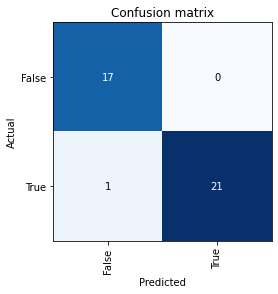

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the covid and healthy CTs in our dataset, respectively. The columns represent the images that the model predicted as cvoid and healthy. Therefore, the diagonal of the matrix shows the images that were classified correctly, and the off-diagonal cells represent those that were classified incorrectly.   


It is (oup until now!) calculated using the validation set.  


The healthy classifier isn’t making almost many mistakes.

In [34]:
interp.print_classification_report()

              precision    recall  f1-score   support

       False       0.94      1.00      0.97        17
        True       1.00      0.95      0.98        22

    accuracy                           0.97        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



In [35]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

17 0 1 21


In [36]:
sensitivity = tp/(tp + fn)
sensitivity

0.9545454545454546

**Type II error**
In this case the model has a sensitivity of 95% and hence is capable of correctly detecting 95% True Positives (i.e. who have Covid) but will miss 5% of False Negatives (patients that actually have Covid but were told they did not)

In [37]:
specificity = tn/(fp + tn)
specificity

1.0

**Type I error**
The model has a specificity of 100% and hence can correctly detect 100% of the time that a patient does not have Covid but will incorrectly classify that 0% of the patients have Covid (False Postive) but actually do not.  

It’s helpful to see where exactly the errors are occurring, to see whether they’re due
    to a dataset problem (e.g., images that aren’t CTs at all, or are labeled incorrectly)
or a model problem (perhaps it isn’t handling images taken with unusual lighting, or
from a different angle, etc.). To do this, we can sort our images by their loss.
The loss is a number that is higher if the model is incorrect (especially if it’s also
confident of its incorrect answer), or if it’s correct but not confident of its correct
answer  

plot_top_losses shows unterp.plot_top_losses(5, nrows=1)s the images
with the highest loss in our dataset. As the title of the output says, each image is
labeled with four things: prediction, actual (target label), loss, and probability. The
probability here is the confidence level, from zero to one, that the model has
assigned to its prediction:

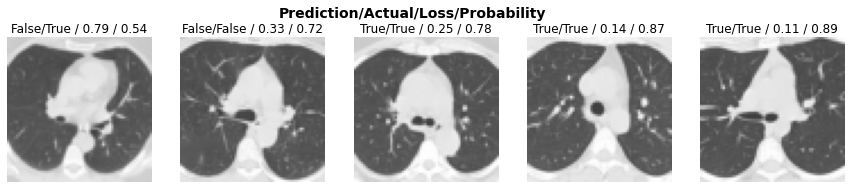

In [29]:
interp.plot_top_losses(5, nrows=1)

The intuitive approach to doing data cleaning is to do it before you train a model.
But in this case, a model can help us find data issues more quickly
and easily. So, we normally prefer to train a quick and simple model first, and then
use it to help us with data cleaning.

**Let’s check that this model actually works**  

In [17]:
import ipywidgets as widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Now you can pass the uploaded file to the model.

In [19]:
img = PILImage.create(uploader.data[0])
is_healthy,_,probs = learn.predict(img)
print(f"Is this a healthy image?: {is_healthy}.")
print(f"Probability it's a healthy CT: {probs[1].item():.6f}")
print(f"Probability it's a covid CT: {probs[0].item():.6f}")

Is this a healthy image?: False.
Probability it's a healthy CT: 0.024232
Probability it's a covid CT: 0.975767


Continute with tasks from **Future Work**
**Deploying on new data** 

Evaluate raw accuracy on never-before-used data (testing set)  

Investigate types of errors using confusion matrix.

In [41]:
learn.export()
#learn.predict('path/to/your/image.jpg')

We can load the model using load_learner('path/to/model/export.pkl')    

load_learner remembers the classes, the transforms used or the normalization in the data, the model, its weigths... The only argument needed is the folder where the 'export.pkl' file is.